In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers            import Input, Lambda, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose, concatenate
import matplotlib.pyplot        as plt
import numpy as np
from keras.utils                        import plot_model
import sys
import os

# Ruta absoluta o relativa al directorio donde está el archivo
directory = os.path.abspath("/home/guiomar/Desktop/CODES/DLCODES")

# Agregar el directorio al sys.path
sys.path.append(directory)

2024-09-12 14:11:44.172389: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-12 14:11:44.179252: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 14:11:44.189141: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 14:11:44.189154: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 14:11:44.195870: I tensorflow/core/platform/cpu_feature_gua

In [16]:
class Shape:
    def __init__(self,w,h,epoch,batch_size):
        self.w=w
        self.h=h
        self.epoch=epoch
        self.batch_size=batch_size

class U_Net(Shape):	
    def __init__(self,w,h,epoch,batch_size,ch,train_data,train_data_sol,val_data,val_data_sol):
         super().__init__(w,h,epoch,batch_size)
         self.ch=ch
         self.train_data=train_data
         self.val_data=val_data
         self.train_data_sol=train_data_sol
         self.val_data_sol=val_data_sol
        
    def conv_block(input_tensor, num_filters):
        x=layers.Conv2D(num_filters, num_filters, activation='relu', padding='same')(input_tensor)
        x = BatchNormalization()(x)
        x=layers.Conv2D(num_filters, num_filters, activation='relu', padding='same')(x)
        x = BatchNormalization()(x)
        return x
        
    def model(self):
        input_shape=(self.h,self.w,self.ch)
        inputs = layers.Input(shape=input_shape)
         # Encoder
        conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
        conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
        pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
        print(f'conv1 {conv1.shape} pool1 {pool1.shape}')

        conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
        conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
        pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
        print(f'conv2 {conv2.shape} pool2 {pool2.shape}')

        conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
        conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
        pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
        print(f'conv3 {conv3.shape} pool3 {pool3.shape}')

        conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
        conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
        pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
        print(f'conv4 {conv4.shape} pool4 {pool4.shape}')

        conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
        conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
        print(f'conv5 {conv5.shape}')
       
        # Decoder con UpSampling2D
        #up6 = layers.UpSampling2D(size=(2, 2))(conv5)

        up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same")(conv5)
        print(f'Conv2DT up6 {up6.shape}')
        up6 = layers.concatenate([up6, conv4])
        print(f'concatenate  {up6.shape}')
        conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(up6)
        conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)
        print(conv6)

        #up7 = layers.UpSampling2D(size=(2, 2))(conv6)

        up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(conv6)
        up7 = layers.concatenate([up7, conv3])
        conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(up7)
        conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

        #up8 = layers.UpSampling2D(size=(2, 2))(conv7)

        up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(conv7)
        up8 = layers.concatenate([up8, conv2])
        conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(up8)
        conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

        #up9 = layers.UpSampling2D(size=(2, 2))(conv8)

        up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(conv8)
        up9 = layers.concatenate([up9, conv1])
        conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(up9)
        conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)

        outputs = layers.Conv2D(1, 1, activation='relu')(conv9)

        model = models.Model(inputs=[inputs], outputs=[outputs])
        model.summary()
        return model
    
    def percentage_error(self,y_true, y_pred):
        return tf.reduce_mean(tf.abs((y_true - y_pred) / tf.clip_by_value(tf.abs(y_true), 1e-7, tf.float32.max)))


    def lr_rate(self):
        n_steps = self.epoch * math.ceil(len(self.train_data) / self.batch_size)
        scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        0.001, decay_steps=n_steps, decay_rate=0.1)
        return scheduled_learning_rate
    
    def early_stopping(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                        patience=30, 
                        restore_best_weights=True)
        return early_stopping
    
    def compile(self):
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr_rate())
        model = self.model()
        plot_model(model, to_file="U_Net_Ver2.png")
        model.summary()
        model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
        checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints.weights.h5",save_weights_only=True)
        model_fitted= model.fit(self.train_data,self.train_data_sol,batch_size=self.batch_size,
                            validation_data=(self.val_data, self.val_data_sol),epochs=self.epoch,
                            callbacks=[self.early_stopping(),checkpoint_cb])
        callbacks = [tf.keras.callbacks.ModelCheckpoint("unet.keras",save_best_only=True)]
        return model_fitted

    
   

In [3]:
def plot(model):

    loss = model.history['mean_absolute_error']
    val_loss = model.history['val_mean_absolute_error']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training MAE")
    plt.plot(epochs, val_loss, "b", label="Validation MAE")
    plt.title("Training and validation MAE")
    plt.legend()
    plt.show()

    hist= train_model.history
    train_acc  = hist['mean_absolute_error']
    valid_acc  = hist['val_mean_absolute_error']
    train_loss = hist['loss']
    valid_loss = hist['val_loss']


def plot(history):
    epoch_count=range(1, len(history.history['loss']) + 1)
    plt.figure(figsize=(13,4), dpi=150)
    plt.subplot(121)
    plt.plot(epoch_count, history.history['loss'], 'b', label = 'training loss')
    plt.plot(epoch_count, history.history['val_loss'], 'r', label ='validation loss')
    plt.legend()
    plt.ylabel('LOSS')
    plt.xlabel('epoch')

    plt.subplot(122)
    plt.plot(epoch_count, history.history['mean_absolute_error'], 'b', label ='training mae')
    plt.plot(epoch_count, history.history['val_mean_absolute_error'], 'r', label ='validation mae')
    plt.legend()
    plt.ylabel('MAE')
    plt.xlabel('epoch')

    
def save_model(model):

        model_json = model.to_json()
        with open('Param_Model.json', 'w') as json_file:
            json_file.write(model_json)
        model.save_weights('w_model.weights.h5')    
        


****** 		 Loaded  300 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Geometry  *******


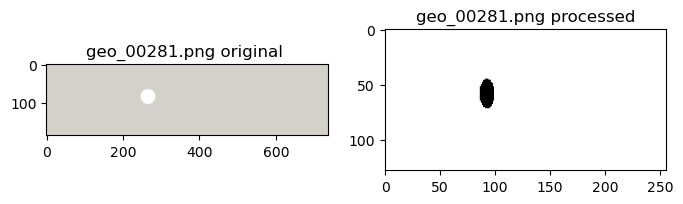


****** 		 Loaded  300 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/U001  *******
				 ==============>  Processed U0001 done!


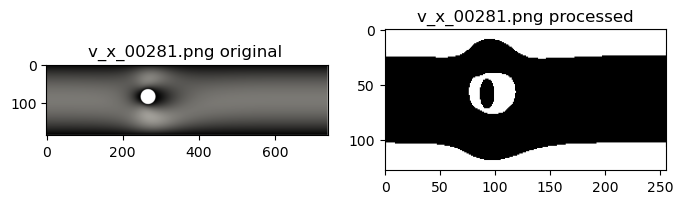

In [4]:

import param
from process_data        import *


##################
# Set the number of cores

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
num_threads = param.n_threads  
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)
####################

# create an object from Dataset class
D=Dataset(param.img_height,param.img_width,param.list_paths,param.train_size,
          param.valid_size,param.tests_size, param.opt_for_data,param.opt_process)

# get train, valid and test dataset
geo_train, geo_valid, geo_tests, flow_train, flow_valid, flow_tests=D.datasets_for_model()


ch=geo_train.shape[3]
w=param.img_width
h= param.img_height
epoch= param.num_epochs 
batch_size=param.batch_size


In [17]:
M=U_Net(w,h,epoch,batch_size,ch,geo_train,flow_train,geo_valid,flow_valid)
M.model()
#model=M.compile()

conv1 (None, 128, 256, 64) pool1 (None, 64, 128, 64)
conv2 (None, 64, 128, 128) pool2 (None, 32, 64, 128)
conv3 (None, 32, 64, 256) pool3 (None, 16, 32, 256)
conv4 (None, 16, 32, 512) pool4 (None, 8, 16, 512)
conv5 (None, 8, 16, 1024)
Conv2DT up6 (None, 16, 32, 512)
concatenate  (None, 16, 32, 1024)
<KerasTensor shape=(None, 16, 32, 512), dtype=float32, sparse=False, name=keras_tensor_146>


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 128, 256,  │        640 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 128, 256,  │     36,928 │ conv2d_77[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 64, 128,   │          0 │ conv2d_78[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 64, 128,   │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 64, 128,   │    147,584 │ conv2d_79[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 32, 64,    │          0 │ conv2d_80[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 32, 64,    │    295,168 │ max_pooling2d_17… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 32, 64,    │    590,080 │ conv2d_81[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 16, 32,    │          0 │ conv2d_82[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 16, 32,    │  1,180,160 │ max_pooling2d_18… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 16, 32,    │  2,359,808 │ conv2d_83[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 8, 16,     │          0 │ conv2d_84[0][0]   │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 8, 16,     │  4,719,616 │ max_pooling2d_19… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_86 (Conv2D)  │ (None, 8, 16,     │  9,438,208 │ conv2d_85[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_16 │ (None, 16, 32,    │  2,097,664 │ conv2d_86[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 16, 32,    │          0 │ conv2d_transpose

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

<Functional name=functional_4, built=True>

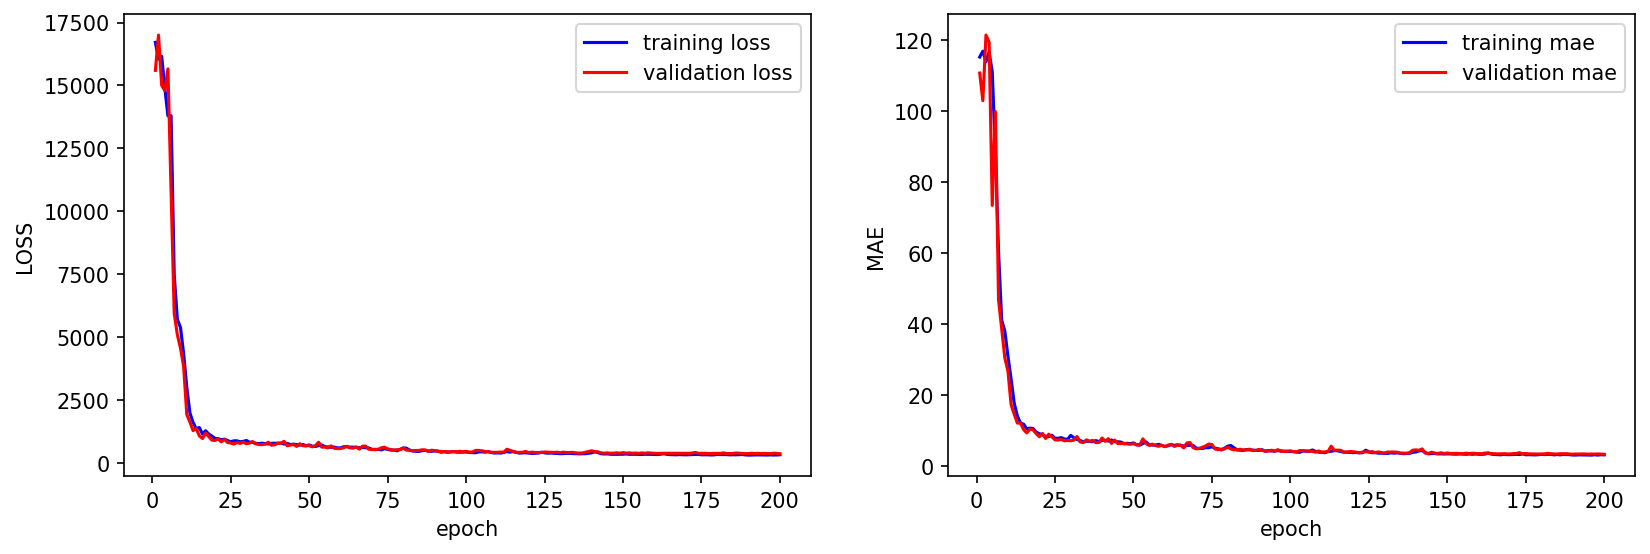

In [18]:
plot(model)